In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
from utils import *
import re
import gensim
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from itertools import combinations
from joblib import dump, load
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adamblock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adamblock/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/adamblock/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adamblock/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/adamblock/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/adamblock/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
corpus_specific_stopwords

{'change',
 'climate',
 'dont',
 'global',
 'he',
 'im',
 'say',
 'thats',
 'thing',
 'warming'}

# Getting and Preprocessing Data

In [4]:
PARENT = "../TelevisionNews/"

In [5]:
cnn, fox, msnbc = get_data(PARENT)

In [58]:
cnn["cleanSnip"] = cnn["Snippet"].apply(lambda x: preprocessing(x, stop_words,False))
fox["cleanSnip"] = fox["Snippet"].apply(lambda x: preprocessing(x, stop_words,False))
msnbc["cleanSnip"] = msnbc["Snippet"].apply(lambda x: preprocessing(x, stop_words,False))

In [59]:
all_shows = pd.concat([cnn,fox,msnbc])

# Model Selection with `gensim`

In [60]:
corpus = list(all_shows["cleanSnip"])

In [62]:
dictionary = gensim.corpora.Dictionary(corpus)

In [65]:
common_corpus = [dictionary.doc2bow(text) for text in corpus]

## Training NMF models

In [89]:
cm = CoherenceModel(model=nmf, texts=all_shows["cleanSnip"], coherence='c_v')
coherence = cm.get_coherence()

In [91]:
topic_range = range(5,17)
nmf_models = []
for k in topic_range:
    print(f"Working on k = {k}")
    model = Nmf(common_corpus, num_topics=k, id2word=dictionary)
    nmf_models.append(model)

Working on k = 5
Working on k = 6
Working on k = 7
Working on k = 8
Working on k = 9
Working on k = 10
Working on k = 11
Working on k = 12
Working on k = 13
Working on k = 14
Working on k = 15
Working on k = 16


## Getting Coherences

In [143]:
coherence_models = []
coherences = []
for k in topic_range:
    print(f"Working on k = {k}")
    coherence_model = CoherenceModel(model=nmf_models[k -5], texts=all_shows["cleanSnip"], coherence='c_v')
    coherence = coherence_model.get_coherence()
    coherence_models.append(coherence_model)
    coherences.append(coherence)
    

Working on k = 5
Working on k = 6
Working on k = 7
Working on k = 8
Working on k = 9
Working on k = 10
Working on k = 11
Working on k = 12
Working on k = 13
Working on k = 14
Working on k = 15
Working on k = 16


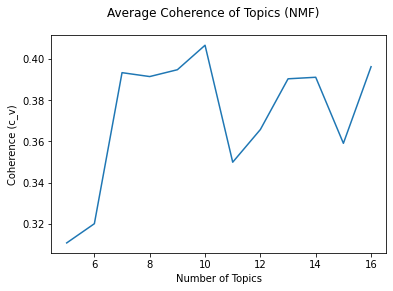

In [151]:
fig, ax = plt.subplots()
ax.plot(topic_range, coherences)
ax.set_xlabel("Number of Topics")
ax.set_ylabel("Coherence (c_v)")
fig.suptitle("Average Coherence of Topics (NMF)")
fig.savefig("./plots/Coherences.png")
plt.show()


## Showing Topic words with `gensim`

In [135]:
def get_words(topic):
    words = []
    i = 0
    while i < len(topic):
        char = topic[i]

        if char == "*":
            i += 2
            word = ""
            char = topic[i]
            while char.isalpha():
                word += char
                i += 1
                char = topic[i]
            words += [word]
            i+=1
        else:
            i += 1
        
    return words
                

In [141]:
def show_topic(model, num_words):
    i = 0
    for _, topic in model.show_topics(0,num_words):
        words = get_words(topic)
        out = f"Topic {i}:\t"
        for word in words:
            out += word + ", "
        print(out)
        i+= 1

# TFIDF and NMF

In [8]:
def display_topics(model, feature_names, no_top_words=5):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [9]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(all_shows['cleanSnip'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [153]:
NUM_TOPICS = 10

In [154]:
nmf = NMF(n_components=NUM_TOPICS).fit(tfidf)

/Users/adamblock/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [155]:
display_topics(nmf, tfidf_feature_names,10)

Topic 0:
new year one time right well back much next last
Topic 1:
gas greenhouse emission cut growing fuel reduce potential keep half
Topic 2:
going get touched everywhere pot impacted specie melting go youre
Topic 3:
president trump obama said house donald white paris administration hoax
Topic 4:
talk scientist sensor road tree network car internet everything call
Topic 5:
issue care health like republican immigration democrat important gun reform
Topic 6:
think he would going well something lot there really important
Topic 7:
world state country united america nation threat make facing leader
Topic 8:
people want american lot like thing get job young tax
Topic 9:
believe know science real scientist said human doesnt question man


In [156]:
dump(nmf, f"./models/NMF_all_{NUM_TOPICS}_topics.joblib")

['./models/NMF_all_10_topics.joblib']

In [30]:
nmf = load("./models/NMF_all_10_topics.joblib")